# Clasificación de Tweets de desastres naturales

## Enunciado

En esta competición, se plantea la construcción de un modelo de aprendizaje automático que realice predicciones sobre qué Tweets tratan de desastres reales y cuáles no.

https://www.kaggle.com/vstepanenko/disaster-tweets

### Imports

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pandas as pd
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
import re
from html.parser import HTMLParser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from tensorflow import keras
import IPython
import tensorflow as tf

# Lectura del conjunto de datos

In [2]:
df = pd.read_csv('repo/tweets.csv')
X_train, X_test = train_test_split(df, test_size=0.2)
X_train

,id,keyword,location,text,target
4244,4244,displaced,NaN,"#ChurchInAction Brothers &amp; Sisters, let us...",1
7990,7990,outbreak,"Male', Maldives",Hey assholes maybe its not good thing to hold ...,0
5136,5136,explode,NaN,". ""We need to explode this myth that we have t...",0
2931,2931,damage,Gay Heaven,LOOK: The extreme damage of ash fall in Pulo i...,1
8776,8776,rubble,NaN,"We get a sprawling view of a nice meadow, it l...",0
...,...,...,...,...,...
6197,6197,harm,"Leeds, England","Finally, also massively important to note that...",0
878,878,blaze,Guam,Tbh I have no Idea what a Chamoru looks like. ...,0
9764,9764,sunk,"England, United Kingdom","And, don't forget, the Conservatives sunk the ...",0
6071,6071,hail,"Kampala, Uganda",Two things about the attack dogs. 1. They have...,0


In [3]:
X_test

,id,keyword,location,text,target
6724,6724,hurricane,United States,Hurricane Recovery for Forest and Conservation...,1
6394,6394,hellfire,NaN,"After Benghazi, Barry sent Rice out to claim i...",0
9868,9868,survive,Kiama NSW Australia,"Joe Hockey spends more in one day, on a BBQ fo...",0
3273,3273,debris,Northern England,Goldcrest flitting around in the debris under ...,0
7935,7935,oil%20spill,United States,He was just trash could be beat by a oil spill,0
...,...,...,...,...,...
6841,6841,injuries,"Ottawa, Ontario",WORKING FIRE: Ottawa Fire Services on scene of...,1
862,862,blaze,"Nairobi, kenya",Blaze was over it😂 https://t.co/DzkQK4G9pb,0
7458,7458,meltdown,NaN,Even after 2 days of media rumours putting my ...,0
2843,2843,curfew,NaN,#Kashmir is still under curfew with no interne...,1


## 2. Visualización del conjunto de datos

In [4]:
print("Tamaño del conjunto de datos de entrenamiento: ", len(X_train))
print("Tamaño del conjunto de datos de pruebas: ", len(X_test))

Tamaño del conjunto de datos de entrenamiento:  9096
Tamaño del conjunto de datos de pruebas:  2274


In [5]:
# Tweets de cada tipo que se encuentran en el conjunto de datos de entrenamiento
X_train['target'].value_counts()

target
0    7426
1    1670
Name: count, dtype: int64

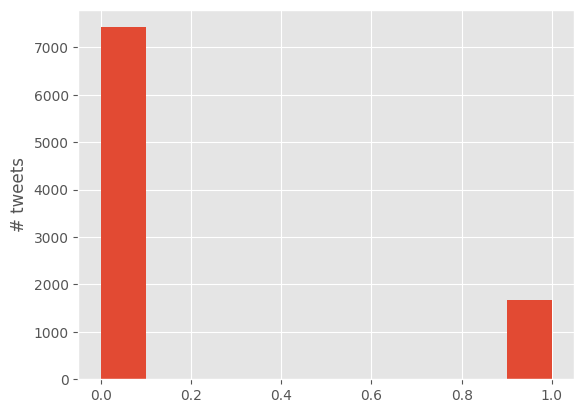

In [6]:
X_train['target'].hist()
plt.ylabel("# tweets")
plt.show()

Siempre conveniente realizar un análisis exploratorio de la distribución de los datos para determinar la mejor manera de resolver el problema

### Número de palabras por Tweet

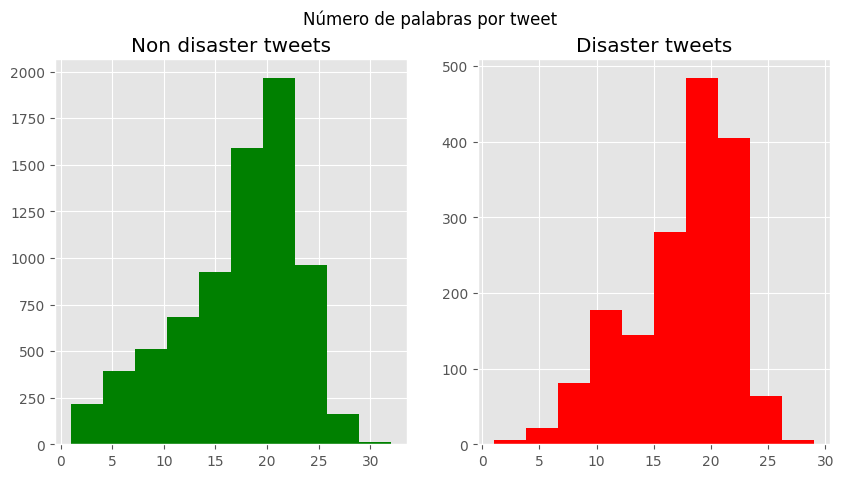

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: len(x))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: len(x))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de palabras por tweet')

plt.show()

### Número de palabras únicas por Tweet

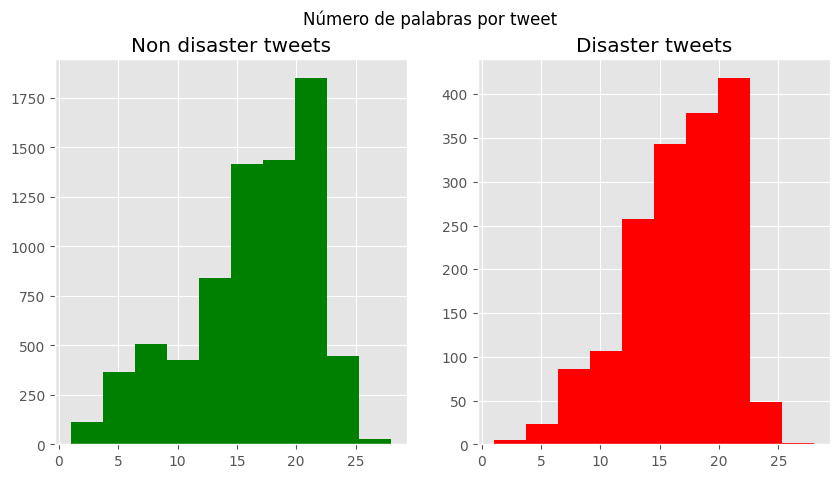

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: len(set(x)))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: len(set(x)))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número de palabras por tweet')

plt.show()

### Longitud media de las palabras por Tweet

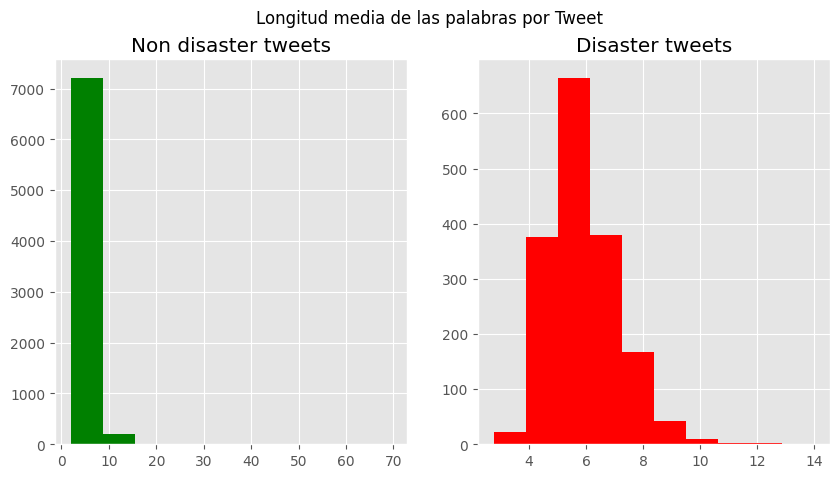

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Calculamos el número de palabras
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.split().map(lambda x: np.mean([len(i) for i in x]))
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.split().map(lambda x: np.mean([len(i) for i in x]))

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Longitud media de las palabras por Tweet')

plt.show()

### Número de caracteres por tweet

In [10]:
# Calculamos el número de caracteres por tweet
tweet_len_0 = X_train[X_train['target'] == 0]['text'].str.len()
tweet_len_1 = X_train[X_train['target'] == 1]['text'].str.len()

ax1.hist(tweet_len_0, color='green')
ax1.set_title('Non disaster tweets')

ax2.hist(tweet_len_1, color='red')
ax2.set_title('Disaster tweets')

fig.suptitle('Número caracteres por tweet')

plt.show()

Podríamos seguir calculando características de entrada como las siguientes:
* Número de palabras de fin por Tweet
* Número de urls por Tweet
* Media de caracteres por Tweet
* Número de caracteres por Tweet
* Número de signos de puntuación por Tweet
* Número de hashtags por Tweet
* Número de @ por tweet

### Stopwords más utilizadas

Estas palabras no tienen un significado por si solas, sino que modifican o acompañan a otras, este grupo suele estar conformado por artículos, pronombres, preposiciones, adverbios e incluso algunos verbos.

En el procesamiento de datos en lenguaje natural son filtradas antes o después del proceso en si, no se consideran por su nulo significado, en el caso de los buscadores como Google no lo consideran al momento de posicionar, pero si al momento de mostrar los resultados de búsqueda.

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def plot_stopwords(label):
    tweets_stopwords = {}
    for words in X_train[X_train['target'] == label]['text'].str.split():
        sw = list(set(words).intersection(stopwords.words('english')))
        for w in sw:
            if w in tweets_stopwords.keys():
                tweets_stopwords[w] += 1
            else:
                tweets_stopwords[w] = 1
                
    top = sorted(tweets_stopwords.items(), key=lambda x:x[1],reverse=True)[:10]
    plt.bar(*zip(*top))
    plt.show()

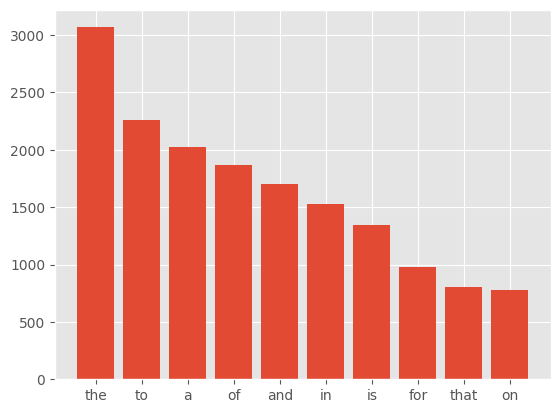

In [13]:
plot_stopwords(0)

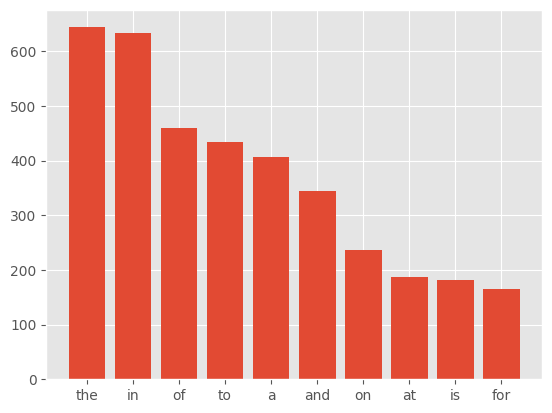

In [14]:
plot_stopwords(1)

### Análisis signos de puntuación

In [15]:
def plot_punctuation(label):
    tweets_stopwords = {}
    for words in X_train[X_train['target'] == label]['text'].str.split():
        sw = list(set(words).intersection(string.punctuation))
        for w in sw:
            if w in tweets_stopwords.keys():
                tweets_stopwords[w] += 1
            else:
                tweets_stopwords[w] = 1
                
    top = sorted(tweets_stopwords.items(), key=lambda x:x[1],reverse=True)[:20]
    plt.figure(figsize=(10, 5))
    plt.bar(*zip(*top))
    plt.show()

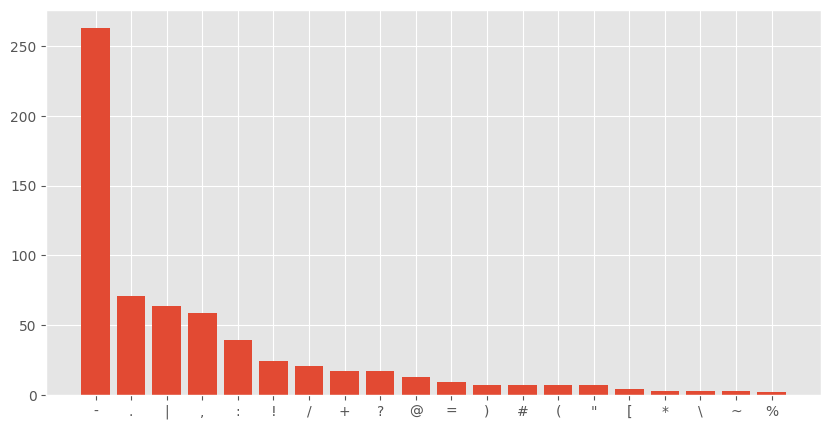

In [16]:
plot_punctuation(0)

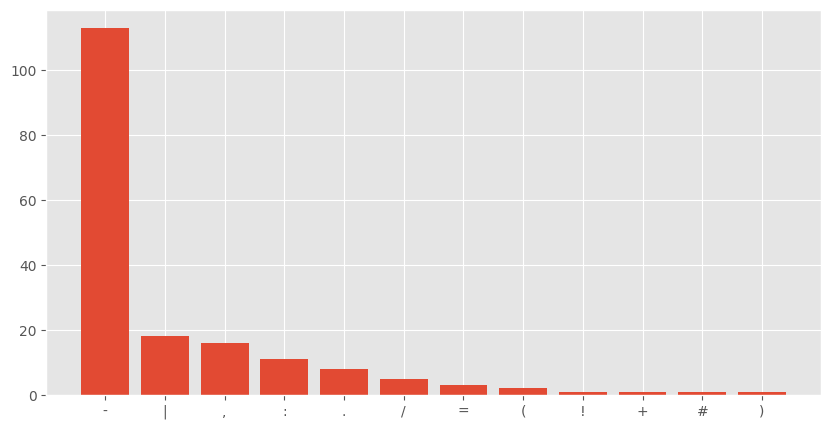

In [17]:
plot_punctuation(1)

### Análisis de Ngramas

In [18]:
cv = CountVectorizer(ngram_range=(2, 2))
sum_words = cv.fit_transform(X_train['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

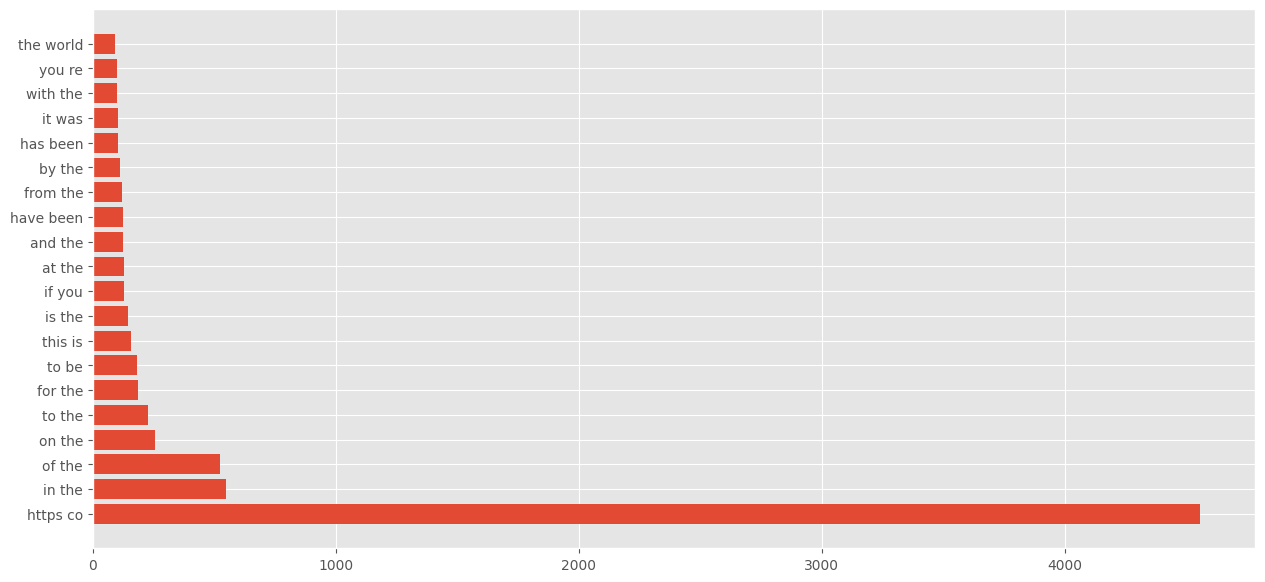

In [19]:
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.show()

## 3. Limpieza del conjunto de datos

In [20]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [21]:
remove_url("Esto es una prueba: http://localhost:8888/notebooks/Desktop/Workspace/Deep%20Neural%20Networks%20Course/11.%20Consideraciones%20de%20un%20proyecto%20de%20Deep%20Learning/code/Disaster%20Tweets.ipynb")

'Esto es una prueba: '

In [22]:
class HTMLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []
        
    def handle_data(self, d):
        self.fed.append(d)
        
    def get_data(self):
        return ''.join(self.fed)

def remove_html(text):
    s = HTMLStripper()
    s.feed(text)
    return s.get_data()

In [23]:
remove_html('<tr><td align="left"><a href="../../issues/51/16.html#article">Phrack World News</a></td>')

'Phrack World News'

In [24]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [25]:
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [26]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [27]:
remove_punctuation("hola #que tal")

'hola que tal'

In [28]:
# Aplicamos nuestras funciones de limpieza del conjunto de datos
X_train_prep = X_train.copy()

X_train_prep['text'] = X_train['text'].apply(remove_url)
X_train_prep['text'] = X_train['text'].apply(remove_html)
X_train_prep['text'] = X_train['text'].apply(remove_emoji)
X_train_prep['text'] = X_train['text'].apply(remove_punctuation)

In [29]:
# Aplicamos nuestras funciones de limpieza del conjunto de datos
X_test_prep = X_test.copy()

X_test_prep['text'] = X_test['text'].apply(remove_url)
X_test_prep['text'] = X_test['text'].apply(remove_html)
X_test_prep['text'] = X_test['text'].apply(remove_emoji)
X_test_prep['text'] = X_test['text'].apply(remove_punctuation)

In [30]:
cv = CountVectorizer(ngram_range=(2, 2))
sum_words = cv.fit_transform(X_train_prep['text']).sum(axis=0)

# Calculamos 
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

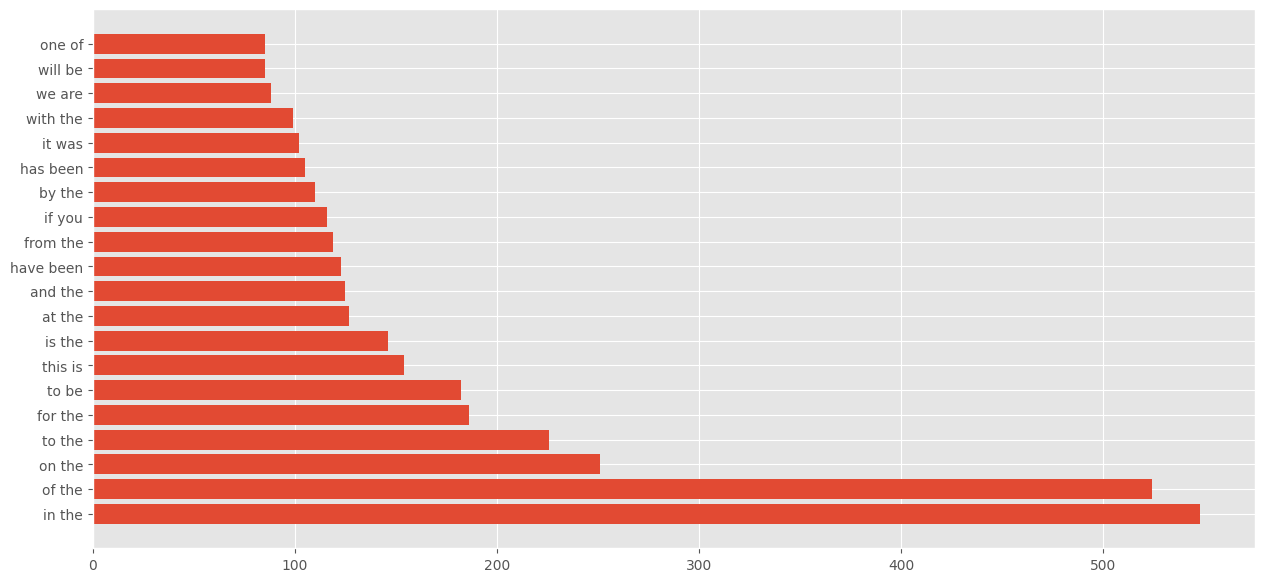

In [31]:
plt.figure(figsize=(15, 7))
plt.barh(*zip(*words_freq))
plt.show()

## 4. Vectorización del conjunto de datos

In [32]:
Y_train = X_train_prep['target']

In [33]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train_prep['text'])

In [34]:
X_train = X_train.toarray()

In [35]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
X_test = vectorizer.transform(X_test_prep['text'])
X_test = X_test.toarray()

## 5. División del conjunto de datos

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [38]:
print("Longitud subcojunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjutno de pruebas: ", len(X_test))

Longitud subcojunto de entrenamiento:  7731
Longitud subconjunto de validación:  1365
Longitud subconjutno de pruebas:  2274


## 6. Construcción del modelo

In [39]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=4, max_value=32, step=4)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)
    
    # Input layer
    model.add(layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
        model.add(layers.Dropout(0.4))
        
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision']
    )
    
    return model

In [40]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=16,
    factor=4,
    directory='test_dir',
    project_name='tweets'
)

INFO:tensorflow:Reloading Tuner from test_dir\tweets\tuner0.json


In [41]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [42]:
# Ejecución del proceso de tuning
tuner.search(
    X_train, 
    Y_train,
    epochs=20,
    validation_data=(X_val, Y_val),
    callbacks=[ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 26s]
val_accuracy: 0.9040293097496033

Best val_accuracy So Far: 0.9040293097496033
Total elapsed time: 00h 00m 52s
INFO:tensorflow:Oracle triggered exit


In [43]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Layers:", best_hps.get('layers'))

Units: 12
Layers: 2


In [51]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    Y_train,
    epochs = 3,
    validation_data = (X_val, Y_val)
)

Epoch 1/3
242/242 [==============================] - 3s 10ms/step - loss: 0.4741 - accuracy: 0.8130 - precision: 0.0000e+00 - val_loss: 0.3198 - val_accuracy: 0.8308 - val_precision: 0.0000e+00
Epoch 2/3
242/242 [==============================] - 2s 10ms/step - loss: 0.2809 - accuracy: 0.8695 - precision: 0.8446 - val_loss: 0.2933 - val_accuracy: 0.8967 - val_precision: 0.7206
Epoch 3/3
242/242 [==============================] - 2s 9ms/step - loss: 0.1384 - accuracy: 0.9502 - precision: 0.9183 - val_loss: 0.3334 - val_accuracy: 0.8835 - val_precision: 0.6552


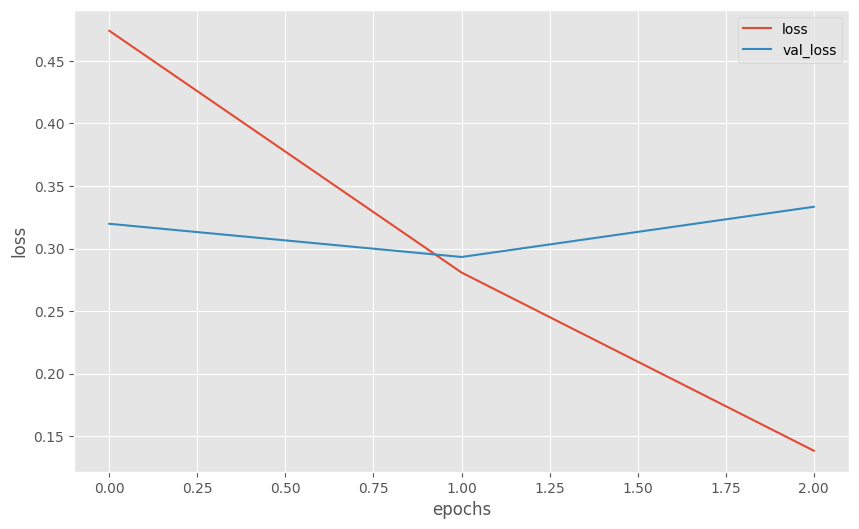

In [52]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

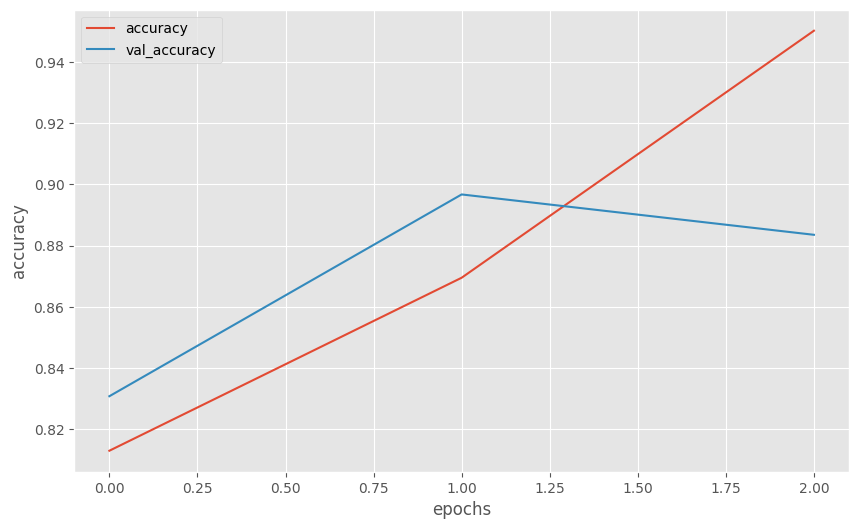

In [53]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [54]:
Y_pred = model.predict(X_test).round(0)
Y_pred

72/72 [==============================] - 0s 2ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [57]:
for i in range(30):
    print("{} - {}".format(X_test_prep['text'].iloc[i], Y_pred[i]))

Hurricane Recovery for Forest and Conservation Nurseries  via httpstcoL008wXTTjL agchat - [0.]
After Benghazi Barry sent Rice out to claim it was a video and perpetuate his incompetence When Iran attacked our Emba… - [0.]
Joe Hockey spends more in one day on a BBQ for his mates than two people on Newstart get to survive on for a whole year T… - [0.]
Goldcrest flitting around in the debris under my feeders earlier today … - [1.]
He was just trash could be beat by a oil spill - [0.]
Design of AR15 could derail charges tied to popular rifle  ABC News  httpstco5MVbreOsBS via - [0.]
How soon can South Carolina replace Sandstorm with something half as fun as Neck Bring the Swag back - [0.]
POGROM IN UMAN OVER SHABBOS Ukrainian Thugs Attack Jews 4 Evacuated To Hospitals httpstco0rpjWbD9oU via  - [1.]
The Internet of Things explosion iot innovation IIoT startup SMM Industry40 CyberSecurity fintech wear… - [0.]
When Jamal Adamson Quincy Chen amp Moises Santiago journey to The City of Need to re